In [186]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [187]:
root_dir = '/kaggle/input/crocodilo/new_fer2013_cropped/train'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

In [188]:
classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [189]:
dataset_path = '/kaggle/input/crocodilo/new_fer2013_cropped'

In [190]:
mean = 0.456
std = 0.224
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((48, 48)),             
    transforms.RandomRotation(degrees=15),       
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.RandomVerticalFlip(p=0.5),   
    transforms.ToTensor(),
    transforms.RandomErasing(
        p=0.5,                  
        scale=(0.01, 0.2),     
        ratio=(0.2, 2.2),  
        value=0                
    ),
    transforms.Normalize([0.456], [0.224])
])

In [191]:
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [192]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [193]:
train_labels = train_dataset.targets  
class_indices = list(range(len(classes)))
class_weights = compute_class_weight(
    'balanced', 
    classes=class_indices, 
    y=train_labels
)

In [194]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

Feature batch shape: torch.Size([32, 1, 48, 48])
Labels batch shape: torch.Size([32])


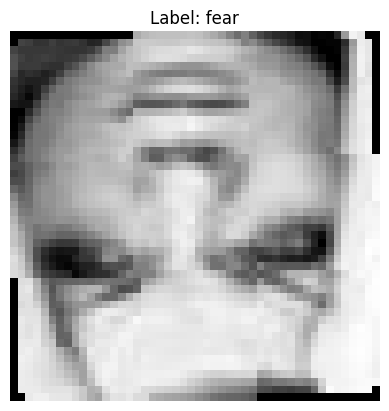

In [195]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[5].permute(1, 2, 0)  # C, H, W -> H, W, C
img = img * std + mean  # unnormalize back to [0,1] range
img = img.clamp(0, 1)
label = train_labels[5].item()
plt.imshow(img.numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [196]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [197]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)
        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [198]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[3, 4, 6, 3],
    n_classes=n_classes
).to(device)

In [199]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [200]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) 
            train_correct += (torch.argmax(outputs, 1) == labels).sum().item()
            total_samples += labels.size(0)

        train_loss /= total_samples
        train_acc = train_correct / total_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            print(f'Best model saved with val acc: {val_acc:.4f}')

        print(f'EPOCH {epoch + 1}/{epochs}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tTrain accuracy: {train_acc:.4f}\tVal accuracy: {val_acc:.4f}')
        scheduler.step()

    return train_losses, val_losses, train_accs, val_accs


In [201]:
epochs = 90 

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2 ,
    momentum=0.9 
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [202]:
train_losses, val_losses, train_accs, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Best model saved with val acc: 0.1682
EPOCH 1/90:	Train loss: 2.0352	Val loss: 1.8811	Train accuracy: 0.1623	Val accuracy: 0.1682
Best model saved with val acc: 0.1829
EPOCH 2/90:	Train loss: 1.9067	Val loss: 1.9496	Train accuracy: 0.2059	Val accuracy: 0.1829
Best model saved with val acc: 0.2469
EPOCH 3/90:	Train loss: 1.8713	Val loss: 1.8362	Train accuracy: 0.2393	Val accuracy: 0.2469
Best model saved with val acc: 0.2530
EPOCH 4/90:	Train loss: 1.8421	Val loss: 1.8524	Train accuracy: 0.2685	Val accuracy: 0.2530
Best model saved with val acc: 0.3028
EPOCH 5/90:	Train loss: 1.8214	Val loss: 2.0336	Train accuracy: 0.2910	Val accuracy: 0.3028
Best model saved with val acc: 0.3375
EPOCH 6/90:	Train loss: 1.7662	Val loss: 1.7088	Train accuracy: 0.3355	Val accuracy: 0.3375
Best model saved with val acc: 0.3659
EPOCH 7/90:	Train loss: 1.7346	Val loss: 1.6794	Train accuracy: 0.3475	Val accuracy: 0.3659
EPOCH 8/90:	Train loss: 1.6804	Val loss: 1.7101	Train accuracy: 0.3704	Val accuracy: 0.362

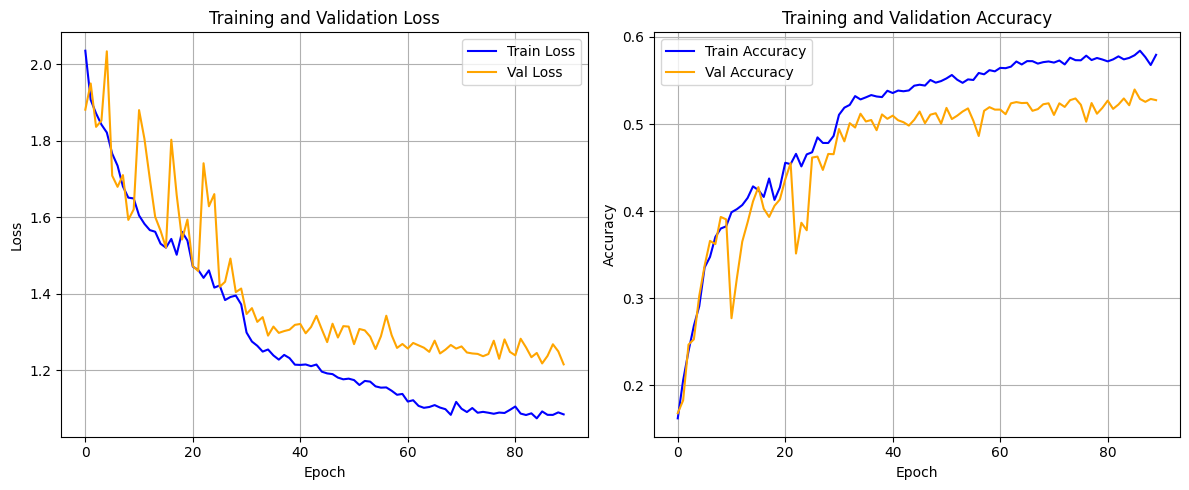

In [203]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses, color='blue', label='Train Loss')
ax[0].plot(val_losses, color='orange', label='Val Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(train_accs, color='blue', label='Train Accuracy')
ax[1].plot(val_accs, color='orange', label='Val Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [204]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5284959688629414
Test accuracy:  0.5492816572001337
